<a href="https://colab.research.google.com/github/Ebadi-Fereshteh/Deep-Learning/blob/main/44-carDetector-cnn/44_carTypeDetector_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
import wandb
from wandb.keras import WandbCallback
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns



In [3]:
wandb.init(project ="car type Detector")

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
config = wandb.config
config.learning_rate = 0.001


In [5]:
# def my_preprocess(image):
#   image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
#   return image

**Dataset**

In [6]:
from google.colab import drive
drive.mount("/content/drive/")


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
dataset_path = "/content/drive/MyDrive/datasets/cars"
width = height = 224

idg = ImageDataGenerator(
    rescale = 1./255,
    # Augmentation
    horizontal_flip = True,
    zoom_range=0.1,
    rotation_range = 15,
    brightness_range = (0.9, 1.1),
    # preprocessing_function = my_preprocess
    validation_split = 0.2
)

train_data = idg.flow_from_directory(
    dataset_path,
    target_size = (width, height),
    class_mode = "categorical",
    subset= "training",
    
)

val_data = idg.flow_from_directory(
    dataset_path,
    target_size=(width, height),
    class_mode= "categorical",
    subset= "validation"
)

Found 648 images belonging to 4 classes.
Found 159 images belonging to 4 classes.


In [8]:
model = tf.keras.models.Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=( width, height, 3)),
        Conv2D(32, (3, 3), activation="relu"),
        MaxPool2D(),
        Conv2D(32, (3, 3), activation="relu"),
        Conv2D(32, (3, 3), activation="relu"),
        MaxPool2D(),
        Conv2D(64, (3, 3), activation="relu"),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPool2D(),

        Flatten(),
        # Dense(512, activation="relu"),
        Dense(256, activation="relu"),
        # Dense(128, activation="relu"),
        Dense(4, activation="softmax"),


])

In [9]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= config.learning_rate),
              loss= tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy']
              )

In [10]:
model_history = model.fit(train_data, epochs= 25, validation_data= val_data, callbacks=[WandbCallback()])

Epoch 1/25
21/21 [==============================] - 230s 11s/step - loss: 1.4610 - accuracy: 0.2809 - val_loss: 1.3667 - val_accuracy: 0.3585 - _timestamp: 1648711799.0000 - _runtime: 337.0000
Epoch 2/25
21/21 [==============================] - 150s 7s/step - loss: 1.3674 - accuracy: 0.3179 - val_loss: 1.3517 - val_accuracy: 0.2830 - _timestamp: 1648711982.0000 - _runtime: 520.0000
Epoch 3/25
21/21 [==============================] - 149s 7s/step - loss: 1.3149 - accuracy: 0.3580 - val_loss: 1.3089 - val_accuracy: 0.3522 - _timestamp: 1648712131.0000 - _runtime: 669.0000
Epoch 4/25
21/21 [==============================] - 149s 7s/step - loss: 1.2911 - accuracy: 0.3796 - val_loss: 1.2597 - val_accuracy: 0.4340 - _timestamp: 1648712332.0000 - _runtime: 870.0000
Epoch 5/25
21/21 [==============================] - 148s 7s/step - loss: 1.2711 - accuracy: 0.4151 - val_loss: 1.3217 - val_accuracy: 0.3522 - _timestamp: 1648712481.0000 - _runtime: 1019.0000
Epoch 6/25
21/21 [====================

In [11]:
model.fit(train_data, epochs= 1, validation_data= val_data, callbacks=[WandbCallback()])

21/21 [==============================] - 150s 7s/step - loss: 0.3949 - accuracy: 0.8565 - val_loss: 1.8153 - val_accuracy: 0.4780 - _timestamp: 1648715995.0000 - _runtime: 4533.0000


**Test**

In [12]:
dataset_path = "/content/drive/MyDrive/datasets/Tests/cars"

idg = ImageDataGenerator(
    rescale = 1./ 255,
)

test_data = idg.flow_from_directory(
    dataset_path,
    target_size = (width, height),
    class_mode = "categorical",
)
test_loss, test_acc= model.evaluate(test_data)


Found 16 images belonging to 4 classes.
1/1 [==============================] - 1s 982ms/step - loss: 1.5265 - accuracy: 0.6250


In [13]:
model.save("/content/drive/MyDrive/models/44-carTypeDetector-cnn.h5")

In [14]:
print(test_loss)
print(test_acc)

1.5265440940856934
0.625


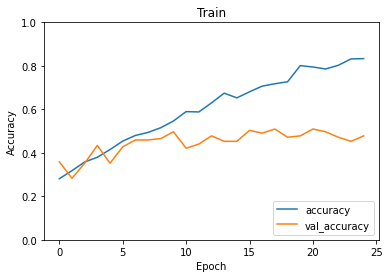

In [15]:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train')
plt.ylim([0, 1])
plt.legend(loc='lower right')

[[3 0 1 0]
 [1 3 0 0]
 [1 1 2 0]
 [1 0 1 2]]


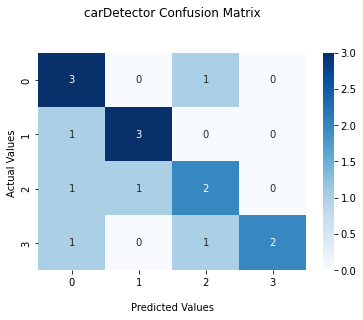

In [16]:
Y_pred = []

for path in test_data.filepaths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (width, height))
    image = image / 255
    image = image.reshape(1, width, height, 3)
    Y_pred.append(np.argmax(model.predict(image)))


cv_confMTX = confusion_matrix(test_data.classes, Y_pred)
print(cv_confMTX)

ax = sns.heatmap(cv_confMTX, annot=True, cmap='Blues')
ax.set_title('carDetector Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

plt.show()

**Inference**

In [17]:
image = cv2.imread("/content/drive/MyDrive/datasets/Inference/cars/image.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (width, height))
image = image / 255
image = image.reshape(1, width, height, 3)  # 3d -> 4D

result = model.predict(image)
print(result)
pred = np.argmax(result)
print(pred)
if pred == 0:
  print("Hatchback 🚙")
  #  print("\U0001F699")
elif pred==1:
  print("Lorry 🚛")
  # print("\U0001F69A")
elif pred==2:
  # print("")
  print("pickup \U0001F6FB")
elif pred==3:
  print("sedan 🚗")
  # print("\U0001F697")  


[[1.4295404e-01 2.9090792e-04 2.5477616e-02 8.3127749e-01]]
3
sedan 🚗
